# Association Rule Mining with MapReduce using mrjob
# This notebook demonstrates how to use MapReduce to find association rules in a dataset.

In [ ]:
!pip install mrjob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 5.6 MB/s eta 0:00:00


In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import tempfile
import subprocess
from io import StringIO
import sys

In [ ]:
# Sample dataset: Market basket transactions
transactions = [
    ['bread', 'milk'],
    ['bread', 'diaper', 'beer', 'eggs'],
    ['milk', 'diaper', 'beer', 'cola'],
    ['bread', 'milk', 'diaper', 'beer'],
    ['bread', 'milk', 'diaper', 'cola']
]

In [ ]:
# Save the dataset to a file
with open('transactions.txt', 'w') as f:
    for transaction in transactions:
        f.write(','.join(transaction) + '\n')

In [ ]:
# Define the MapReduce job for finding frequent itemsets and generating rules
%%writefile association_rules_fixed.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import itertools
import json
import os

class AssociationRules(MRJob):
    def configure_args(self):
        super(AssociationRules, self).configure_args()
        self.add_passthru_arg('--min_support', type=int, default=2, help='Minimum support count')
        self.add_passthru_arg('--phase', type=str, default='itemsets', help='Phase of the algorithm')
        self.add_passthru_arg('--single_item_counts', type=str, default='{}',
                              help='JSON string of single item counts')
        self.add_passthru_arg('--pair_item_counts', type=str, default='{}',
                              help='JSON string of pair item counts')
        self.add_passthru_arg('--num_transactions', type=int, default=0,
                              help='Total number of transactions')

    def steps(self):
        if self.options.phase == 'itemsets':
            return [MRStep(mapper=self.mapper_get_itemsets,
                          reducer=self.reducer_count_itemsets)]
        else:  # phase == 'rules'
            return [MRStep(mapper=self.mapper_get_rules,
                          reducer=self.reducer_output_rules)]

    # Phase 1: Find frequent itemsets
    def mapper_get_itemsets(self, _, line):
        items = line.strip().split(',')

        # Emit single items
        for item in items:
            yield f"single_{item}", 1

        # Emit pairs of items
        if len(items) >= 2:
            for pair in itertools.combinations(sorted(items), 2):
                yield f"pair_{pair[0]}_{pair[1]}", 1

    def reducer_count_itemsets(self, key, counts):
        # Count the occurrences of each itemset
        total = sum(counts)

        # Only yield if support >= min_support
        if total >= self.options.min_support:
            yield key, total

    # Phase 2: Generate association rules
    def mapper_get_rules(self, _, line):
        # Just pass through in this phase
        yield None, 1

    def reducer_output_rules(self, _, counts):
        # Parse the single item and pair item counts from JSON
        single_item_counts = json.loads(self.options.single_item_counts)
        pair_item_counts = json.loads(self.options.pair_item_counts)
        num_transactions = self.options.num_transactions

        # Generate rules from pairs
        for pair_key, support in pair_item_counts.items():
            # Extract the items from the pair key
            # Format is "pair_item1_item2"
            parts = pair_key.split('_')
            if len(parts) >= 3:
                item_a = parts[1]
                item_b = parts[2]

                # Calculate confidence and lift for A -> B
                single_key_a = f"single_{item_a}"
                single_key_b = f"single_{item_b}"

                if single_key_a in single_item_counts and single_key_b in single_item_counts:
                    support_a = single_item_counts[single_key_a]
                    support_b = single_item_counts[single_key_b]

                    # A -> B
                    confidence_a_b = support / support_a
                    lift_a_b = (support * num_transactions) / (support_a * support_b)

                    # B -> A
                    confidence_b_a = support / support_b
                    lift_b_a = lift_a_b  # Lift is symmetric

                    # Yield both rules with their metrics
                    yield f"{item_a} -> {item_b}", (support, support/num_transactions, confidence_a_b, lift_a_b)
                    yield f"{item_b} -> {item_a}", (support, support/num_transactions, confidence_b_a, lift_b_a)

if __name__ == '__main__':
    AssociationRules.run()

Writing association_rules_fixed.py


In [ ]:
!python association_rules_fixed.py --phase=itemsets --min_support=2 transactions.txt > itemsets.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/association_rules_fixed.root.20250312.162958.010105
Running step 1 of 1...
job output is in /tmp/association_rules_fixed.root.20250312.162958.010105/output
Streaming final output from /tmp/association_rules_fixed.root.20250312.162958.010105/output...
Removing temp directory /tmp/association_rules_fixed.root.20250312.162958.010105...


In [ ]:
# Parse the itemsets output to separate single items and pairs
single_item_counts = {}
pair_item_counts = {}

with open('itemsets.txt', 'r') as f:
    for line in f:
        # Split by tab instead of using eval
        parts = line.strip().split('\t')
        if len(parts) == 2:
            key = parts[0].strip('"')  # Remove any quotes
            count = int(parts[1])

            if key.startswith('single_'):
                single_item_counts[key] = count
            elif key.startswith('pair_'):
                pair_item_counts[key] = count

In [ ]:
# Count total transactions
num_transactions = len(transactions)

In [ ]:
import json
import subprocess

cmd = [
    'python', 'association_rules_fixed.py',
    '--phase=rules',
    f'--single_item_counts={json.dumps(single_item_counts)}',
    f'--pair_item_counts={json.dumps(pair_item_counts)}',
    f'--num_transactions={num_transactions}',
    'transactions.txt'
]

with open('rules.txt', 'w') as outfile:
    subprocess.run(cmd, stdout=outfile)

In [ ]:
# Parse and display the rules
rules_data = []
with open('rules.txt', 'r') as f:
    for line in f:
        try:
            # Check if the line contains the expected format
            if "->" in line and "[" in line:
                # Split on the first occurrence of square bracket
                parts = line.split("[", 1)
                if len(parts) == 2:
                    # Extract the rule part
                    rule = parts[0].strip().strip('"')

                    # Extract the metrics part
                    metrics_str = "[" + parts[1].strip()
                    # Use eval to safely parse the list
                    metrics = eval(metrics_str)

                    if len(metrics) >= 4:
                        support, support_pct, confidence, lift = metrics
                        rules_data.append({
                            'rule': rule,
                            'support': support,
                            'support_pct': support_pct * 100,
                            'confidence': confidence * 100,
                            'lift': lift
                        })
        except Exception as e:
            print(f"Error parsing line: {line.strip()}. Error: {e}")


Association Rules:
beer -> diaper: Support=3 (60.0%), Confidence=100.0%, Lift=1.25
diaper -> beer: Support=3 (60.0%), Confidence=75.0%, Lift=1.25
cola -> diaper: Support=2 (40.0%), Confidence=100.0%, Lift=1.25
diaper -> cola: Support=2 (40.0%), Confidence=50.0%, Lift=1.25
cola -> milk: Support=2 (40.0%), Confidence=100.0%, Lift=1.25
milk -> cola: Support=2 (40.0%), Confidence=50.0%, Lift=1.25
bread -> diaper: Support=3 (60.0%), Confidence=75.0%, Lift=0.94
diaper -> bread: Support=3 (60.0%), Confidence=75.0%, Lift=0.94
bread -> milk: Support=3 (60.0%), Confidence=75.0%, Lift=0.94
milk -> bread: Support=3 (60.0%), Confidence=75.0%, Lift=0.94
diaper -> milk: Support=3 (60.0%), Confidence=75.0%, Lift=0.94
milk -> diaper: Support=3 (60.0%), Confidence=75.0%, Lift=0.94
beer -> bread: Support=2 (40.0%), Confidence=66.7%, Lift=0.83
bread -> beer: Support=2 (40.0%), Confidence=50.0%, Lift=0.83
beer -> milk: Support=2 (40.0%), Confidence=66.7%, Lift=0.83
milk -> beer: Support=2 (40.0%), Confide

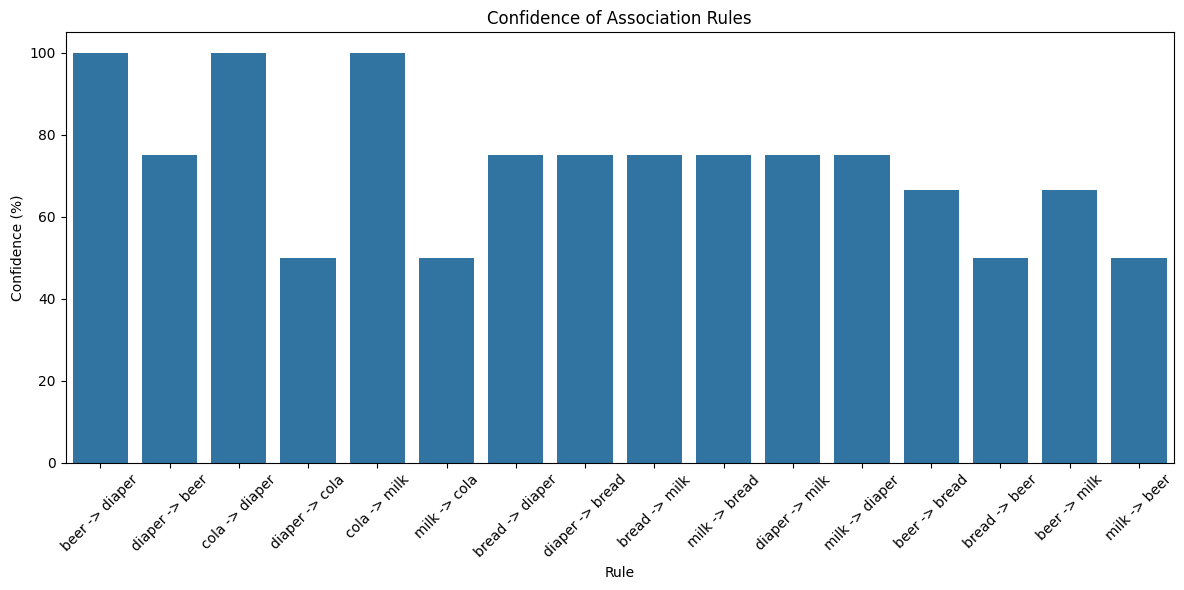

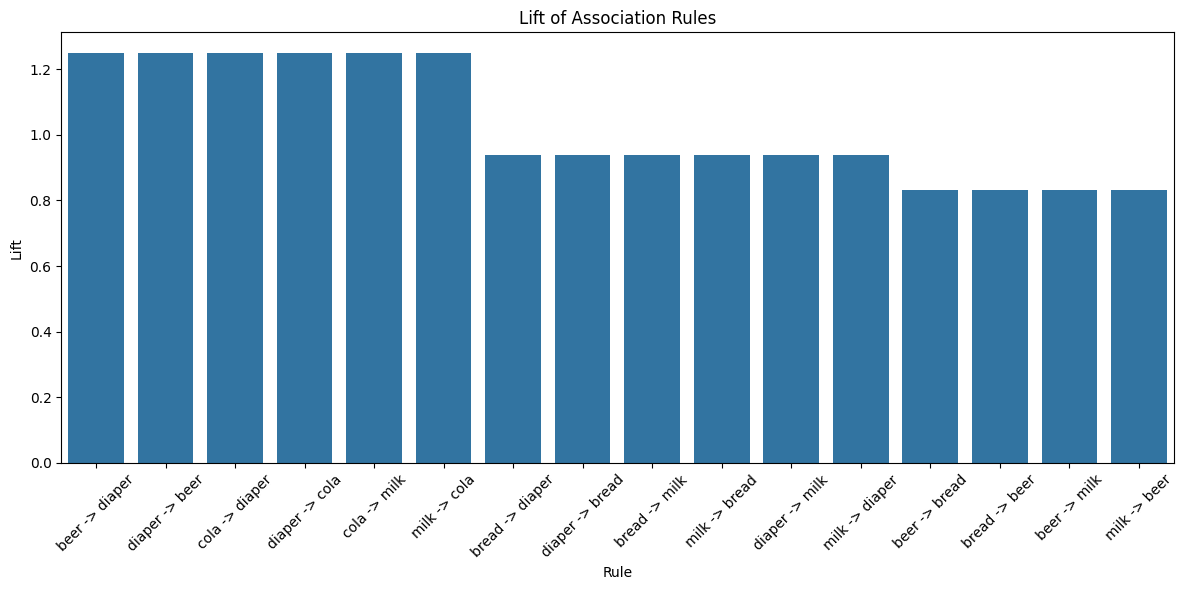

In [ ]:
if rules_data:
    # Create the DataFrame
    df_rules = pd.DataFrame(rules_data)

    # Check if required columns exist
    required_columns = ['rule', 'support', 'confidence', 'lift']
    if all(col in df_rules.columns for col in required_columns):
        # Sort by lift (most interesting rules first)
        df_rules = df_rules.sort_values(by='lift', ascending=False)

        # Display the rules
        print("\nAssociation Rules:")
        for _, row in df_rules.iterrows():
            print(f"{row['rule']}: Support={row['support']} ({row['support_pct']:.1f}%), " +
                  f"Confidence={row['confidence']:.1f}%, Lift={row['lift']:.2f}")

        # Visualize the results
        plt.figure(figsize=(12, 6))
        sns.barplot(x='rule', y='confidence', data=df_rules)
        plt.title('Confidence of Association Rules')
        plt.ylabel('Confidence (%)')
        plt.xlabel('Rule')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(12, 6))
        sns.barplot(x='rule', y='lift', data=df_rules)
        plt.title('Lift of Association Rules')
        plt.ylabel('Lift')
        plt.xlabel('Rule')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        missing = [col for col in required_columns if col not in df_rules.columns]
        print(f"Missing required columns: {missing}")
else:
    print("No valid rules data was parsed from the output file.")
